In [1]:
!pip install scikit-survival
!pip install scikit-learn
!pip install pycox
!pip install captum

You should consider upgrading via the '/home/jskrajny/PycharmProjects/xai_team/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/jskrajny/PycharmProjects/xai_team/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/jskrajny/PycharmProjects/xai_team/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/jskrajny/PycharmProjects/xai_team/venv/bin/python -m pip install --upgrade pip' command.


In [45]:
import numpy as np
import pandas as pd
import sklearn.model_selection as model_selection

import torch
import torchtuples

import sksurv.datasets as datasets
import sksurv.linear_model as linear_model
import sksurv.ensemble as ensemble
import sksurv.functions as functions

import pycox
from pycox.datasets import metabric, nwtco
import pycox.evaluation as evaluation

import captum.attr as attr
import survshap

import matplotlib.pyplot as plt

import torchtuples as tt

In [3]:
class DeepHitSingleWrapper:
    def __init__(self, net, optim):
        self.net = net
        self.optim = optim
        
    def fit(self, train_data, train_target, val_data, val_target, callbacks, epochs=10):
        cuts = self.net.net[-1].out_features
        lt = pycox.models.DeepHitSingle.label_transform(cuts)
        
        train_data = train_data.values
        train_target = lt.fit_transform(train_target["duration"], train_target["event"])
        
        val_data = val_data.values
        val_target = lt.transform(val_target["duration"], val_target["event"])
        
        self.model = pycox.models.DeepHitSingle(self.net, self.optim, device='cpu', duration_index=lt.cuts)
        log = self.model.fit(train_data, train_target, 256, epochs=epochs, callbacks=callbacks, val_data=(val_data, val_target))
        
        self.event_times_ = lt.cuts

        return log

    def predict_surv_df(self, data):
        return self.model.predict_surv_df(data.values)
        
    def score(self, data, target):
        surv_df = self.predict_surv_df(data)
        eval_surv = evaluation.EvalSurv(surv_df, target["duration"], target["event"])
        
        return eval_surv.concordance_td()
    
    def predict_survival_function(self, data):
        surv_df = self.predict_surv_df(data)
        ret = [functions.StepFunction(surv_df.index.values, values) for values in surv_df.T.values]
        
        return np.array(ret)

In [4]:
import time


class Wrapper:
    def __init__(self, model, data, explainer):
        self.model = model
        self.baseline = torch.zeros(data.values.shape)
        self.explainer = explainer(self.model.net)
        
    def __call__(self, observation):
        data = torch.tensor(observation.values)

        attributions = []
        st = time.time()
        for i in range(len(self.model.event_times_)):
            attribution = self.explainer.attribute(data, self.baseline, i).detach().numpy()
            attributions.append(attribution)
        attributions = np.stack(attributions, axis=2)

        print(f"Explainer working time in seconds = {time.time() - st}")

        step_functions = {}
        for i, column in enumerate(observation.columns):
            step_functions[column] = [
                functions.StepFunction(self.model.event_times_, np.cumsum(attributions[j, i])) \
                for j in range(len(observation))
            ]

        return pd.DataFrame(step_functions)

In [5]:
class DeepLiftShapWrapper(Wrapper):
    def __init__(self, model, data):
        super(DeepLiftShapWrapper, self).__init__(model, data, attr.DeepLiftShap)
        
        self.model = model
        self.baseline = torch.randn(data.values.shape) * 0.001
        self.explainer = attr.DeepLiftShap(self.model.net)

In [6]:
class DeepLiftWrapper(Wrapper):
    def __init__(self, model, data):
        super(DeepLiftWrapper, self).__init__(model, data, attr.DeepLift)
        
        self.model = model
        self.baseline = torch.zeros((1, data.values.shape[1]))
        self.explainer = attr.DeepLift(self.model.net)

In [7]:
class IntegratedGradientsWrapper(Wrapper):
    def __init__(self, model, data):
        super(IntegratedGradientsWrapper, self).__init__(model, data, attr.DeepLiftShap)
        
        self.model = model
        self.baseline = torch.zeros((1, data.values.shape[1]))
        self.explainer = attr.IntegratedGradients(self.model.net)

In [8]:
class SurvShapWrapper:
    def __init__(self, model, data, target):
        self.model = model
        self.explainer = survshap.SurvivalModelExplainer(self.model, data, target)

    def __call__(self, observation):     
        surv_shap = survshap.PredictSurvSHAP()
        st = time.time()
        surv_shap.fit(self.explainer, observation, self.model.event_times_)
        print(f"Explainer working time in seconds = {time.time() - st}")
        result = surv_shap.result
        
        step_functions = {}
        for name, group in result.groupby(by="variable_name"):            
            step_functions[name] = [
                functions.StepFunction(self.model.event_times_, attributions)
                for attributions in group.iloc[:, 5:].values
            ]
            
        return pd.DataFrame(step_functions)

In [9]:
def plot(results):
    Xs = [result.x for result in results]
    Ys = [result.y for result in results]
    labels = list(results.index)

    plt.plot(np.array(Xs).T, np.array(Ys).T, label=labels)
    plt.legend(bbox_to_anchor=(1, 1))

# METABRIC EXPERIMENT - The Molecular Taxonomy of Breast Cancer International Consortium

x0 - MKI67
x1 - EGFR
x2 - PGR
x3 - ERBB2
x4 - hormone treatment indicator
x5 - radiotherapy indicator
x6 - chemotherapy indicator
x7 - ER-positive indicator
x8 - age at diagnosis

In [28]:
df = metabric.read_df()

data, target = datasets.get_x_y(df, attr_labels=["event", "duration"], pos_label=1)
train_data, test_data, train_target, test_target = model_selection.train_test_split(data, target)

for feature_name in train_data.columns:
    max_value = train_data[feature_name].max()
    min_value = train_data[feature_name].min()
    train_data[feature_name] = (train_data[feature_name] - min_value) / (max_value - min_value)
    test_data[feature_name] = (test_data[feature_name] - min_value) / (max_value - min_value)
train_data, train_target

(            x0        x1        x2        x3   x4   x5   x6   x7        x8
 1754  0.032227  0.338238  0.509383  0.560412  1.0  1.0  0.0  1.0  0.775417
 3     0.161039  0.073758  0.274869  0.216906  0.0  0.0  0.0  0.0  0.604895
 1772  0.097585  0.145561  0.401721  0.220439  1.0  1.0  1.0  1.0  0.161915
 296   0.018094  0.448515  0.188538  0.427966  1.0  0.0  0.0  1.0  0.578268
 1783  0.170591  0.119096  0.978283  0.568851  0.0  1.0  1.0  0.0  0.500672
 ...        ...       ...       ...       ...  ...  ...  ...  ...       ...
 582   0.047773  0.106259  0.493937  0.233946  1.0  0.0  0.0  1.0  0.638246
 1550  0.269278  0.071041  0.405361  0.218900  1.0  1.0  0.0  1.0  0.513179
 1074  0.323065  0.045096  0.402073  0.493151  1.0  1.0  1.0  0.0  0.361754
 187   0.243229  0.062016  0.849803  0.331484  0.0  1.0  1.0  0.0  0.343464
 689   0.089957  0.350098  0.467502  0.234313  1.0  1.0  1.0  1.0  0.864847
 
 [1428 rows x 9 columns],
 array([( True, 209.03334045), (False, 239.30000305),
      

## TRAINING

#### METABRIC - RANDOM FOREST

In [29]:
random_survival_forest = ensemble.RandomSurvivalForest()
random_survival_forest.fit(train_data, train_target)

print(f"Train score = {random_survival_forest.score(train_data, train_target)}")
print(f"Test score = {random_survival_forest.score(test_data, test_target)}")

Train score = 0.8847621195924011
Test score = 0.6309620533038532


#### METABRIC - COXPH

In [30]:
CoxPH_survival_analysis = linear_model.CoxPHSurvivalAnalysis()
CoxPH_survival_analysis.fit(train_data, train_target)

print(f"Train score = {CoxPH_survival_analysis.score(train_data, train_target)}")
print(f"Test score = {CoxPH_survival_analysis.score(test_data, test_target)}")

Train score = 0.6375772163852154
Test score = 0.6369157820429148


#### METABRIC - DEEPHIT

0:	[0s / 0s],		train_loss: 0.8888,	val_loss: 0.8423
1:	[0s / 0s],		train_loss: 0.8521,	val_loss: 0.8351
2:	[0s / 0s],		train_loss: 0.8357,	val_loss: 0.8272
3:	[0s / 0s],		train_loss: 0.8198,	val_loss: 0.8230
4:	[0s / 0s],		train_loss: 0.8078,	val_loss: 0.8225
5:	[0s / 0s],		train_loss: 0.7996,	val_loss: 0.8240
6:	[0s / 0s],		train_loss: 0.7892,	val_loss: 0.8245
7:	[0s / 1s],		train_loss: 0.7831,	val_loss: 0.8254
Train score = 0.6850782102480848
Test score = 0.6607057256990679


/home/jskrajny/PycharmProjects/xai_team/venv/lib/python3.8/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic
/home/jskrajny/PycharmProjects/xai_team/venv/lib/python3.8/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


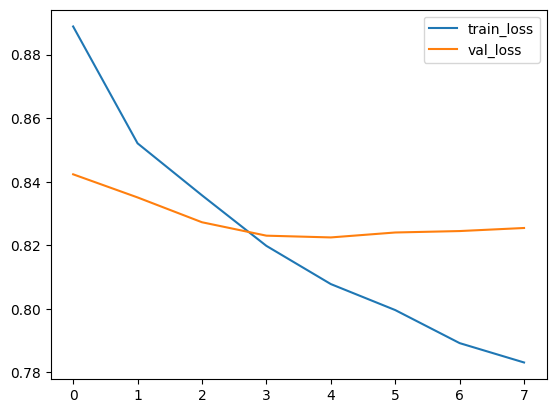

In [38]:
net = torchtuples.practical.MLPVanilla(train_data.shape[1], [32, 128, 32], 100)
optim = torch.optim.Adam(net.parameters(), lr=2e-3)

deep_hit_single = DeepHitSingleWrapper(net, optim)
log = deep_hit_single.fit(train_data, train_target, test_data, test_target, [tt.callbacks.EarlyStopping(patience=3)], epochs=100)

print(f"Train score = {deep_hit_single.score(train_data, train_target)}")
print(f"Test score = {deep_hit_single.score(test_data, test_target)}")

_ = log.plot()

## EXPLAINING

#### METABRIC - SURVSHAP - COXPH

Explainer working time in seconds = 37.33140206336975


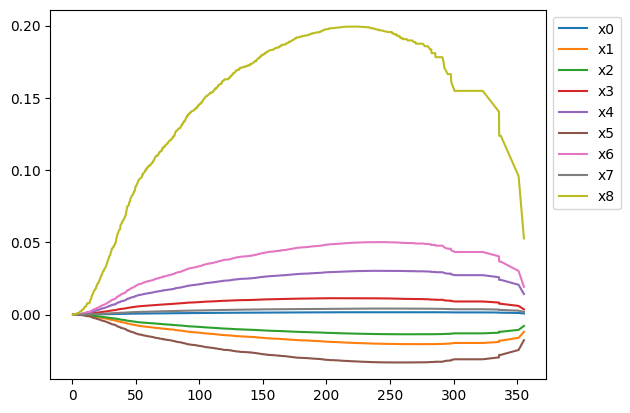

In [39]:
surv_shap_wrapper = SurvShapWrapper(CoxPH_survival_analysis, test_data, test_target)
surv_shap_results = surv_shap_wrapper(test_data.iloc[[0]]).iloc[0]

plot(surv_shap_results)

#### METABRIC - SURVSHAP - RANDOM FOREST

Explainer working time in seconds = 69.6776831150055


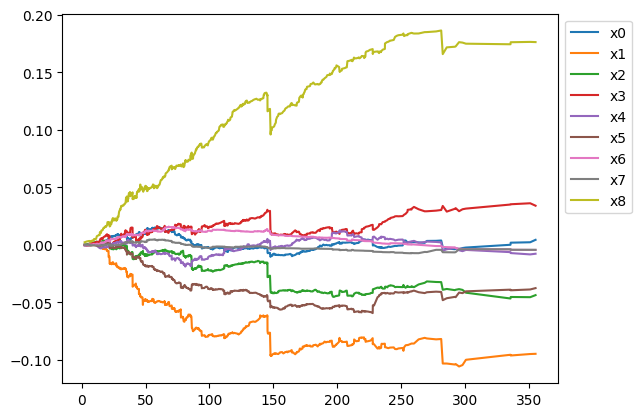

In [40]:
surv_shap_wrapper = SurvShapWrapper(random_survival_forest, test_data, test_target)
surv_shap_results = surv_shap_wrapper(test_data.iloc[[0]]).iloc[0]

plot(surv_shap_results)

#### METABRIC - SURVSHAP - DEEPHIT

Explainer working time in seconds = 25.6657612323761


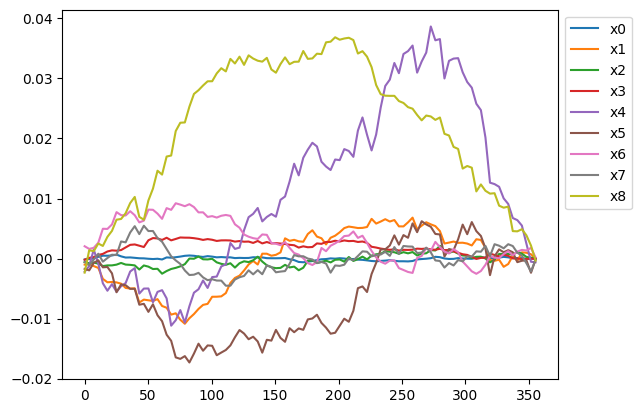

In [41]:
surv_shap_wrapper = SurvShapWrapper(deep_hit_single, test_data, test_target)
surv_shap_results = surv_shap_wrapper(test_data.iloc[[0]]).iloc[0]

plot(surv_shap_results)

#### METABRIC - DEEPLIFT - DEEPHIT

/home/jskrajny/PycharmProjects/xai_team/venv/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Explainer working time in seconds = 2.18267560005188


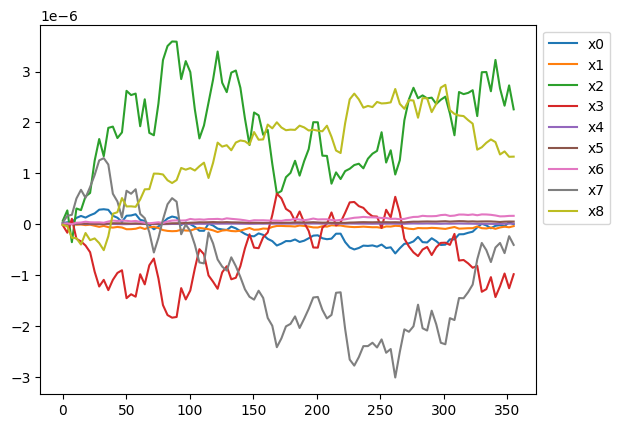

In [42]:
deep_lift_shap_wrapper = DeepLiftShapWrapper(deep_hit_single, test_data)
deep_lift_shap_results = deep_lift_shap_wrapper(test_data.iloc[[0]]).iloc[0]

plot(deep_lift_shap_results)

#### METABRIC - INTEGRATED GRADIENT - DEEPHIT

Explainer working time in seconds = 1.484100580215454


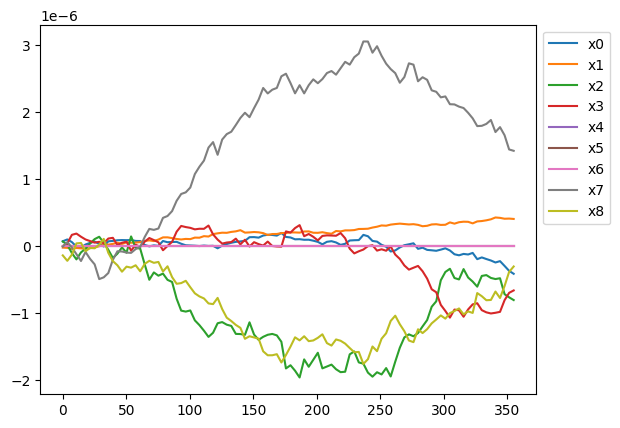

In [43]:
integrated_gradient_wrapper = IntegratedGradientsWrapper(deep_hit_single, test_data)
integrated_gradient_results = integrated_gradient_wrapper(test_data.iloc[[0]]).iloc[0]

plot(integrated_gradient_results)

# SUPPORT EXPERIMENT - Study to Understand Prognoses Preferences Outcomes and Risks of Treatment

x0 - age
x1 - sex
x2 - race
x3 - number of comorbidities
x4 - presence of diabetes
x5 - presence of dementia
x6 - presence of cancer
x7 - mean arterial blood pressure
x8 - heart rate
x9 - respiration rate
x10 - temperature
x11 - white blood cell count
x12 - serum’s sodium
x13 - and serum’s creatinine

In [61]:
from pycox.datasets import support

df = support.read_df()
data, target = datasets.get_x_y(df, attr_labels=["event", "duration"], pos_label=1)
train_data, test_data, train_target, test_target = model_selection.train_test_split(data, target)

for feature_name in train_data.columns:
    max_value = train_data[feature_name].max()
    min_value = train_data[feature_name].min()
    train_data[feature_name] = (train_data[feature_name] - min_value) / (max_value - min_value)
    test_data[feature_name] = (test_data[feature_name] - min_value) / (max_value - min_value)
train_data, train_target

(            x0   x1        x2   x3   x4   x5   x6        x7        x8  \
 8666  0.776696  0.0  0.666667  0.2  1.0  0.0  1.0  0.400000  0.333333   
 8123  0.068053  0.0  0.111111  0.4  0.0  0.0  0.0  0.651282  0.466667   
 3984  0.483751  1.0  0.000000  0.2  0.0  0.0  0.5  0.369231  0.413333   
 481   0.386927  1.0  0.000000  0.2  0.0  0.0  0.5  0.379487  0.366667   
 8614  0.526198  1.0  0.222222  0.4  1.0  0.0  0.5  0.323077  0.346667   
 ...        ...  ...       ...  ...  ...  ...  ...       ...       ...   
 1952  0.662518  1.0  0.111111  0.2  1.0  0.0  0.5  0.651282  0.383333   
 7827  0.676803  0.0  0.444444  0.2  1.0  0.0  0.5  0.369231  0.416667   
 2571  0.653680  1.0  0.222222  0.2  0.0  0.0  0.5  0.512821  0.333333   
 3954  0.063694  0.0  0.333333  0.6  1.0  0.0  0.5  0.194872  0.460000   
 11    0.393794  0.0  0.111111  0.2  0.0  0.0  0.5  0.297436  0.316667   
 
             x9       x10       x11       x12       x13  
 8666  0.288889  0.489622  0.380282  0.068496  0.093

In [55]:
random_survival_forest = ensemble.RandomSurvivalForest()
random_survival_forest.fit(train_data, train_target)

print(f"Train score = {random_survival_forest.score(train_data, train_target)}")
print(f"Test score = {random_survival_forest.score(test_data, test_target)}")

Train score = 0.8397704601922028
Test score = 0.6107087670085711


In [62]:
CoxPH_survival_analysis = linear_model.CoxPHSurvivalAnalysis()
CoxPH_survival_analysis.fit(train_data, train_target)

print(f"Train score = {CoxPH_survival_analysis.score(train_data, train_target)}")
print(f"Test score = {CoxPH_survival_analysis.score(test_data, test_target)}")

Train score = 0.5763602459975388
Test score = 0.562891443743447


0:	[0s / 0s],		train_loss: 1.2712,	val_loss: 1.2686
1:	[0s / 1s],		train_loss: 1.2594,	val_loss: 1.2707
2:	[0s / 1s],		train_loss: 1.2502,	val_loss: 1.2672
3:	[0s / 1s],		train_loss: 1.2415,	val_loss: 1.2627
4:	[0s / 2s],		train_loss: 1.2336,	val_loss: 1.2572
5:	[0s / 2s],		train_loss: 1.2254,	val_loss: 1.2511
6:	[0s / 2s],		train_loss: 1.2178,	val_loss: 1.2458
7:	[0s / 2s],		train_loss: 1.2104,	val_loss: 1.2390
8:	[0s / 3s],		train_loss: 1.2022,	val_loss: 1.2329
9:	[0s / 3s],		train_loss: 1.1949,	val_loss: 1.2268
10:	[0s / 3s],		train_loss: 1.1860,	val_loss: 1.2206
11:	[0s / 3s],		train_loss: 1.1774,	val_loss: 1.2139
12:	[0s / 4s],		train_loss: 1.1688,	val_loss: 1.2075
13:	[0s / 4s],		train_loss: 1.1595,	val_loss: 1.2013
14:	[0s / 4s],		train_loss: 1.1510,	val_loss: 1.1936
15:	[0s / 4s],		train_loss: 1.1417,	val_loss: 1.1879
16:	[0s / 5s],		train_loss: 1.1323,	val_loss: 1.1823
17:	[0s / 5s],		train_loss: 1.1231,	val_loss: 1.1762
18:	[1s / 6s],		train_loss: 1.1151,	val_loss: 1.1710
19:

/home/jskrajny/PycharmProjects/xai_team/venv/lib/python3.8/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


Train score = 0.6244201831644567
Test score = 0.5910618076224643


/home/jskrajny/PycharmProjects/xai_team/venv/lib/python3.8/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  assert pd.Series(self.index_surv).is_monotonic


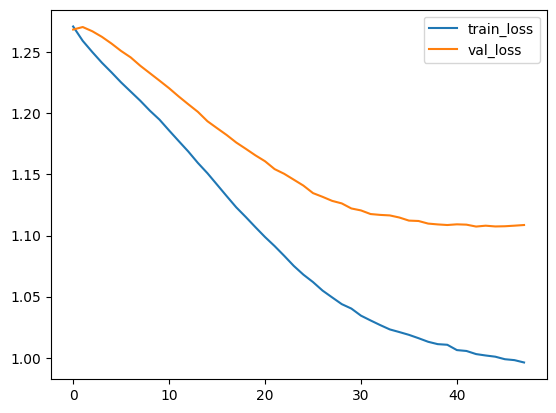

In [59]:
net = torchtuples.practical.MLPVanilla(train_data.shape[1], [32, 32], 500)
optim = torch.optim.Adam(net.parameters(), lr=5e-4)

deep_hit_single = DeepHitSingleWrapper(net, optim)
log = deep_hit_single.fit(train_data, train_target, test_data, test_target, [tt.callbacks.EarlyStopping(patience=5)], epochs=100)

print(f"Train score = {deep_hit_single.score(train_data, train_target)}")
print(f"Test score = {deep_hit_single.score(test_data, test_target)}")

_ = log.plot()

In [63]:
urv_shap_wrapper = SurvShapWrapper(CoxPH_survival_analysis, test_data, test_target)
surv_shap_results = surv_shap_wrapper(test_data.iloc[[0]]).iloc[0]

plot(surv_shap_results)

ValueError: Length mismatch: Expected axis has 14 elements, new values have 9 elements

In [ ]:
surv_shap_wrapper = SurvShapWrapper(random_survival_forest, test_data, test_target)
surv_shap_results = surv_shap_wrapper(test_data.iloc[[0]]).iloc[0]

plot(surv_shap_results)

In [ ]:
surv_shap_wrapper = SurvShapWrapper(deep_hit_single, test_data, test_target)
surv_shap_results = surv_shap_wrapper(test_data.iloc[[0]]).iloc[0]

plot(surv_shap_results)

In [ ]:
deep_lift_shap_wrapper = DeepLiftShapWrapper(deep_hit_single, test_data)
deep_lift_shap_results = deep_lift_shap_wrapper(test_data.iloc[[0]]).iloc[0]

plot(deep_lift_shap_results)

In [ ]:
integrated_gradient_wrapper = IntegratedGradientsWrapper(deep_hit_single, test_data)
integrated_gradient_results = integrated_gradient_wrapper(test_data.iloc[[0]]).iloc[0]

plot(integrated_gradient_results)